In [1]:
from Skipass.data import DataSkipass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config; set_config(display='diagram')
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten, LSTM, GRU, Dropout, Masking
from keras.callbacks import EarlyStopping

2021-09-01 23:20:23.778334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-01 23:20:23.778358: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ns = not scaled / ss = standard scaler / rs = robust scaler / ms = minmax scaler
# nt = not typed / dat = datetime / int = integer / flt = float


column_dict = {
    'date':['ns','dat'],
    'numer_sta':['ns','nt'],
    'Latitude':['ns','nt'],
    'Longitude':['ns','nt'],
    'Altitude':['ns','int'],
    'pmer':['ss','int'],
    'dd':['ss','int'],
    'ff':['ss','flt'],
    't':['ss','flt'],
    'u':['ss','int'],
    'ssfrai':['rs','flt'],
    'rr3':['ms','flt']
}

Dtype_col = {'int':[],'flt':[],'dat':[]}
for i in column_dict:
    if column_dict[i][1] == 'int':
        Dtype_col['int'].append(i)
    elif column_dict[i][1] == 'flt':
        Dtype_col['flt'].append(i)
    elif column_dict[i][1] == 'dat':
        Dtype_col['dat'].append(i)  

Not_encoded = ['date','numer_sta','Latitude','Longitude','Altitude']
Num_col_standard = ['pmer','dd','ff','t','u']
Num_col_robust = ['ssfrai']
Num_col_minmax = ['rr3']
Cat_col = []
Col_select = Not_encoded + Num_col_standard + Num_col_robust + Num_col_minmax + Cat_col
Col_base = Num_col_standard + Num_col_robust + Num_col_minmax + Cat_col
Stations = [7481,7650,7661,7690,7591,7577,7643]

In [3]:
df_synop = DataSkipass().df

/home/romain/.pyenv/versions/3.8.6/envs/skipass/lib/python3.8/site-packages/Skipass/data.py:46: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  df_data = self.import_data()


In [4]:
df_synop = df_synop[df_synop.numer_sta.isin(Stations)][Col_select]
df_synop = df_synop.replace("mq",value=np.nan)
df_synop = df_synop.replace("/",value=np.nan)
df_synop['date'] = pd.to_datetime(df_synop['date'],format='%Y%m%d%H%M%S',errors='coerce')
df_synop

col_synop_float = Col_select[1:]

for i in col_synop_float:
    df_synop[i] = df_synop[i].astype(float,errors='ignore')

In [5]:
#def to_date(x):
#    return pd.to_datetime(x, format='%Y%m%d%H%M%S',errors='coerce')

In [6]:
#tr_date = FunctionTransformer(to_date)

In [7]:
cont_prepro = Pipeline([
    ("imputer",SimpleImputer(strategy = "mean")),
    ("scaler",StandardScaler())
])

In [8]:
preprocessor = ColumnTransformer([
    ('num_transformer', cont_prepro,Col_base)],
    remainder='passthrough' 
)

#preprocessor = ColumnTransformer([
#    ('num_transformer', cont_prepro,Col_base),
#    ('date_transfromer',tr_date, ['date'])
#])

In [9]:
df_synop1 = pd.DataFrame(preprocessor.fit_transform(df_synop),columns=Col_base+Not_encoded)

for i in col_synop_float:
    df_synop1[i] = df_synop1[i].astype(float,errors='ignore')
    
df_synop1 = pd.DataFrame(df_synop1,columns=Col_base + Not_encoded)
df_synop1 = df_synop1.sort_values('date',ascending=True)

In [36]:
def splitdata(df):
    
    training_l = int(0.8*len(df_synop1))
    test_l = len(df_synop1)-training_l
    train_l = int(0.8*training_l)
    valid_l = int(training_l-train_l)
    
    test = df.tail(test_l)
    training = df.head(training_l)
    valid = training.tail(valid_l)
    train = training.head(train_l)
    
    return train, valid, test

In [37]:
df_train, df_valid, df_test = splitdata(df_synop1)

In [38]:
df_train.shape, df_valid.shape, df_test.shape

((150708, 12), (37678, 12), (47097, 12))

In [47]:
day_per_seq = 15
obs_per_day = 24/3
obs_per_seq = int(day_per_seq * obs_per_day)
target = 1
sequence_train = 250
sequence_test = int(sequence_train * 0.5)
sequence_valid = int(sequence_train * 0.2)

In [48]:
def subsample_sequence(df, length, target):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    x = np.random.randint(1,df.shape[0]-length-target)
    df_sample = df[x:x+length]
    df_target = df[x+length+target-1:x+length+target]
    return df_sample, df_target

In [49]:
def sequence(df, lenght, target, sequence):
    d = {}
    X_ = []
    y_ = []
    for i in df.numer_sta.unique():
        d[int(i)] = df.loc[df.numer_sta == i]

    for i in d.keys():
        for j in range(sequence):
            df_sample, df_target = subsample_sequence(d[i],lenght,target)
            X_.append(df_sample)
            y_.append(df_target)

    for i in X_:
        i.drop(columns=['date','numer_sta'],inplace=True)

    for i in y_:
        i.drop(columns=['date','numer_sta','Latitude','Longitude','Altitude'],inplace=True)

    X, y = [],[]

    for i in X_:
        X.append(i.to_numpy())
    X = np.array(X)
    for i in y_:
        y.append(i.to_numpy())
    y = np.array(y)
    y = y.reshape(y.shape[0],y.shape[-1])
    
    return X, y

In [50]:
X_train, y_train = sequence(df_train, obs_per_seq, target, sequence_train)
X_valid, y_valid = sequence(df_valid, obs_per_seq, target, sequence_valid)
X_test, y_test = sequence(df_test, obs_per_seq, target, sequence_test)

In [51]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=1000,restore_best_weights=True)

In [52]:
model = Sequential()
model.add(GRU(units=160,activation='tanh',return_sequences=True, input_shape=(obs_per_seq,10)))
model.add(GRU(units=160,activation='tanh',return_sequences=True,))
model.add(GRU(units=160,activation='tanh'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(7, activation='linear'))
model.compile(loss="mean_squared_error", optimizer='rmsprop', metrics=['mae','mse'])

In [53]:
history = model.fit(X_train,y_train, epochs=100000, validation_data=(X_valid,y_valid), verbose=1, callbacks=[es])

Epoch 1/100000
55/55 [==============================] - 15s 222ms/step - loss: 0.7946 - mae: 0.6224 - mse: 0.7946 - val_loss: 0.7708 - val_mae: 0.6002 - val_mse: 0.7708
Epoch 2/100000
55/55 [==============================] - 13s 229ms/step - loss: 0.7313 - mae: 0.5942 - mse: 0.7313 - val_loss: 0.6616 - val_mae: 0.5573 - val_mse: 0.6616
Epoch 3/100000
55/55 [==============================] - 14s 249ms/step - loss: 0.6040 - mae: 0.5328 - mse: 0.6040 - val_loss: 0.5344 - val_mae: 0.4856 - val_mse: 0.5344
Epoch 4/100000
55/55 [==============================] - 14s 248ms/step - loss: 0.5069 - mae: 0.4748 - mse: 0.5069 - val_loss: 0.4484 - val_mae: 0.4387 - val_mse: 0.4484
Epoch 5/100000
55/55 [==============================] - 14s 248ms/step - loss: 0.4423 - mae: 0.4391 - mse: 0.4423 - val_loss: 0.4127 - val_mae: 0.4154 - val_mse: 0.4127
Epoch 6/100000
55/55 [==============================] - 14s 260ms/step - loss: 0.4016 - mae: 0.4125 - mse: 0.4016 - val_loss: 0.3716 - val_mae: 0.3885 - va

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 120, 160)          109440    
_________________________________________________________________
lstm_4 (LSTM)                (None, 120, 320)          615680    
_________________________________________________________________
lstm_5 (LSTM)                (None, 160)               307840    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               32200     
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 1407      
Total params: 1,106,767
Trainable params: 1,106,767
Non-trainable params: 0
____________________________________________

In [54]:
model.evaluate(X_test,y_test)

28/28 [==============================] - 2s 67ms/step - loss: 0.9334 - mae: 0.3316 - mse: 0.9334


[0.9333570599555969, 0.33155712485313416, 0.9333570599555969]

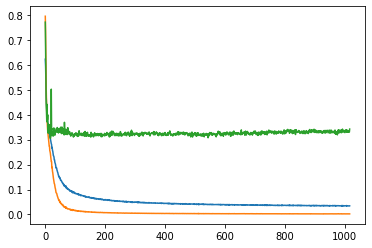

In [59]:
plt.plot(history.history['mae'])
plt.plot(history.history['mse'])
plt.plot(history.history['val_loss'])